In [1]:
import tempfile
import boto3
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm

# my ml bucket name that I created (remember to update this with yours)
BUCKET_NAME = 'my-ml-space54gsdf543'

# intialize s3 client to save model later
s3_client = boto3.client('s3')

# Download Data, Save it in S3, and Read it from S3

#### Downloading Data Helper Function

If you're curious about the math going on here, this [link](https://math.libretexts.org/Bookshelves/Calculus/Book%3A_Calculus_(OpenStax)/11%3A_Parametric_Equations_and_Polar_Coordinates/11.03%3A_Polar_Coordinates#:~:text=However%2C%20if%20we%20use%20polar,spiral%20emanates%20from%20the%20origin.) has more details.

In [2]:
# helper function to emulate downloading data into a pandas DataFrame
def download_data_to_pandas():
    '''
    Pretend this function is downloading data from the internet somewhere.
    '''
    
    def random_1D_array(num, upper_bound=.2):
        '''
        This function outputs 1D-array with the shape (num,) 
        full of random elements in [0,upper_bound)
        '''
        return np.random.random_sample((num,))*upper_bound
    
    # number of data points
    n = 1000

    r = np.linspace(0.0, 10.0, num=n)
    
    x0_0 = r*(np.cos(r) + random_1D_array(num=n))
    x1_0 = r*(np.sin(r) + random_1D_array(num=n))

    x0_1 = r*(np.cos(r + np.pi) + random_1D_array(num=n))
    x1_1 = r*(np.sin(r + np.pi) + random_1D_array(num=n))

    class0 = np.vstack([x0_0, x1_0, np.ones_like(x0_0)]).T
    class1 = np.vstack([x0_1, x1_1, np.zeros_like(x0_1)]).T

    return pd.DataFrame(
            np.vstack([class0, class1]), columns=['x0', 'x1', 'y']
    )

In [3]:
# download data points into a pandas DataFrame
df = download_data_to_pandas()

# you can just save a dataframe right to an S3 path using pandas
df.to_csv(f's3://{BUCKET_NAME}/datafile.csv', index=False)

In [4]:
# read data that you uploaded to s3 into memory using pandas
df = pd.read_csv(f's3://{BUCKET_NAME}/datafile.csv')

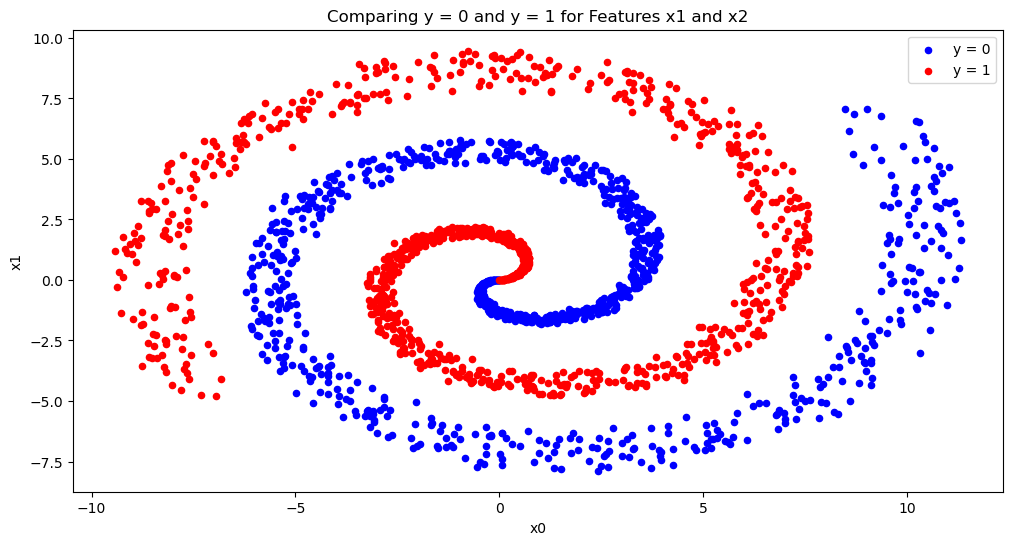

In [5]:
# plot data to see what it looks like
title = 'Comparing y = 0 and y = 1 for Features x1 and x2'
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

df[df['y'] == 0].plot.scatter('x0','x1', ax=ax, color='b', label='y = 0')
df[df['y'] == 1].plot.scatter('x0','x1', ax=ax, color='r', label='y = 1')
ax.set_title(title)
plt.show()

# Train a Model on Data

In [6]:
# put data in format model prefers
X, y = df[['x0', 'x1']].values, df[['y']].values.ravel()

# split training and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [7]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [8]:
accuracy = np.sum((y_test - clf.predict(X_test) == 0))/y_test.shape[0]
print(f'Our accuracy is: {accuracy}')

Our accuracy is: 0.9125


# Plot Decision Boundary

Appologies if the below cell runs slowly. I just copy and pasted this from this stack overflow post: https://stackoverflow.com/questions/51297423/plot-scikit-learn-sklearn-svm-decision-boundary-surface

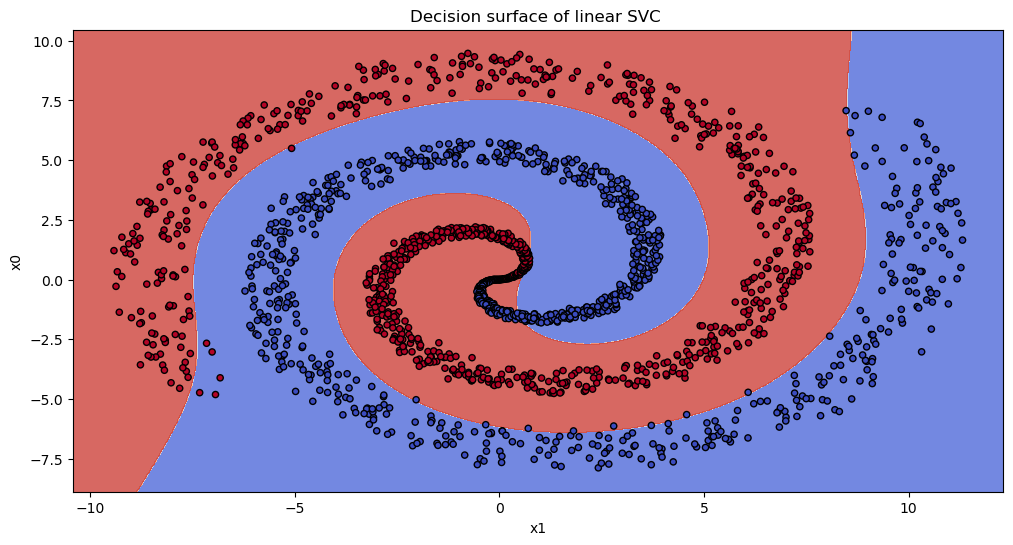

In [9]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h), 
        np.arange(y_min, y_max, h)
    )
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

fig, ax = plt.subplots(figsize=(12, 6))
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('x0')
ax.set_xlabel('x1')
ax.set_title(title)
plt.show()

# Save model to S3 and Read it Back into Memory Again

The below code is adapted from this stackoverflow post: https://stackoverflow.com/questions/56571731/how-to-save-sklearn-model-on-s3-using-joblib-dump

In [10]:
# name to save model as in s3
model_name = "model.pkl"

# save to s3
with tempfile.TemporaryFile() as fp:
    joblib.dump(clf, fp)
    fp.seek(0)
    s3_client.put_object(
        Body=fp.read(), 
        Bucket=BUCKET_NAME, 
        Key=model_name
    )

print(f'model saved to s3 as: {model_name}')

model saved to s3 as: model.pkl


In [11]:
# read model into memory from s3
with tempfile.TemporaryFile() as fp:
    s3_client.download_fileobj(
        Fileobj=fp, 
        Bucket=BUCKET_NAME, 
        Key=model_name
    )
    fp.seek(0)
    model = joblib.load(fp)

accuracy = np.sum((y_test - model.predict(X_test) == 0))/y_test.shape[0]
print(f'Our accuracy of model loaded from s3 is: {accuracy}!')

Our accuracy of model loaded from s3 is: 0.9125!
